# Yes/No 音声認識

ref. https://www.tensorflow.org/tutorials/audio/simple_audio  
ref. https://aidemy.net/magazine/661/  
ref. https://tips-memo.com/python-f0  

In [1]:
import sys
import math
import random
import pyaudio
import wave
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import recorder
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
np.random.seed(seed)

In [2]:
# 録音して自分の声をyes/no各20サンプル作成(固定長)
n_datas = 20
samplerate = 16000
data_dir = "./data/yes_no_detection"

In [4]:
def record(filename_prefix, rec_seconds):
    print("input start index or Enter to skip:")
    _input = input()
    if not _input:
        print("skip")
        return
    index = int(_input)
    print(index)
    while True:
        print("input Enter to rec or 'end' to end:")
        if input() == 'end':
            print("end")
            break
        rec = recorder.Recorder(channels=1, rate=samplerate)
        rec.record(rec_seconds, f'{data_dir}/{filename_prefix}{index}.wav')
        rec.close()
        index += 1
        print(f"next: {index}")

In [5]:
# 対話形式で生成
record(filename_prefix="yes_", rec_seconds=2)

input start index or Enter to skip:
skip


In [6]:
# 対話形式で生成
record(filename_prefix="no_", rec_seconds=2)

input start index or Enter to skip:
skip


In [3]:
# 録音ファイルをロード
X_no = []
X_yes = []
for i in range(n_datas):
    no, _ = librosa.load(f'{data_dir}/no_{i}.wav', sr=samplerate, mono=True)
    yes, _ = librosa.load(f'{data_dir}/yes_{i}.wav', sr=samplerate, mono=True)
    X_no.append(no)
    X_yes.append(yes)

## 特徴

In [4]:
print('Audio playback')
display.display(display.Audio(X_no[0], rate=samplerate))

Audio playback


### Waveform

In [9]:
def plot_samples(X, label):
    # case of n = 20
    rows = 4
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    fig.suptitle(f"Waveform of '{label}'", fontsize=20)

    n = rows * cols
    t = np.arange(0, X[0].shape[0]/samplerate, 1/samplerate)
    for i, x in enumerate(X):
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        ax.plot(t, x)
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))

        if i+1 >= n:
            break

    plt.show()
    

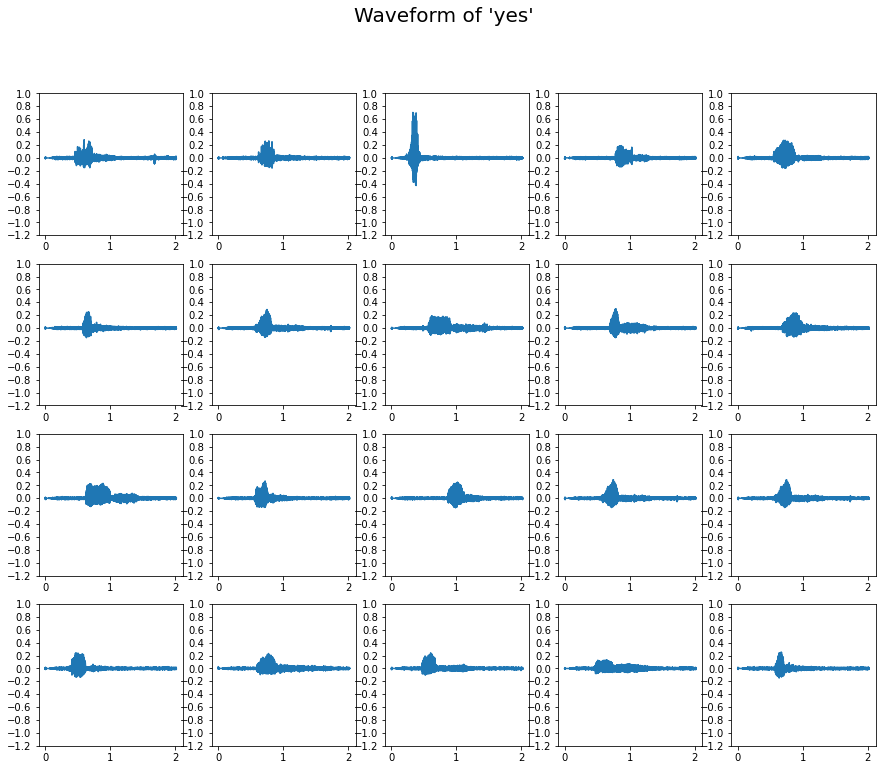

In [10]:
plot_samples(X_yes, "yes")

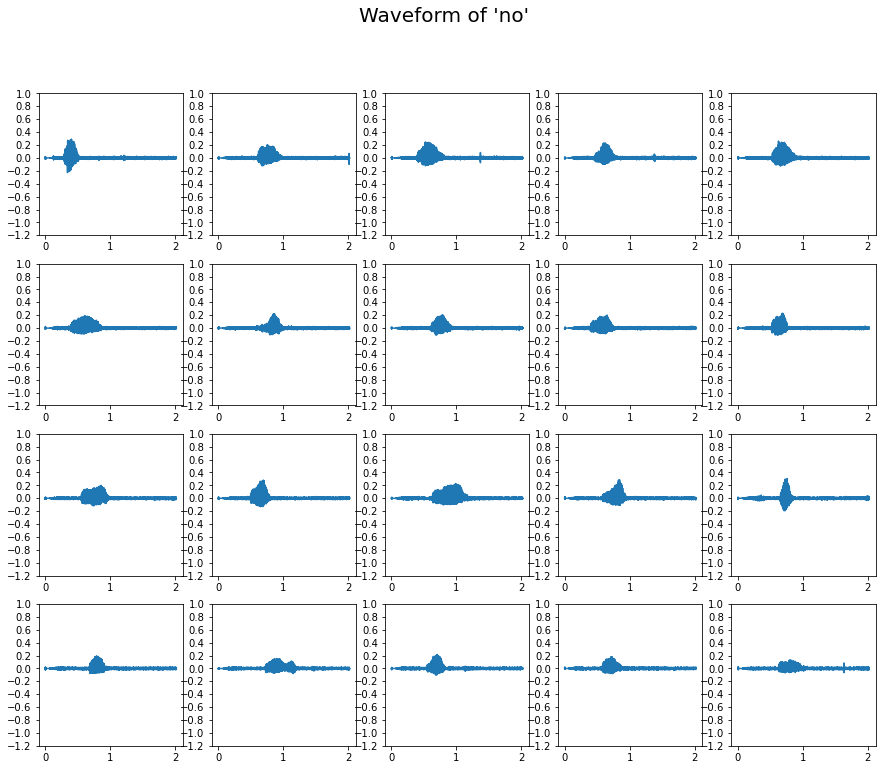

In [11]:
plot_samples(X_no, "no")

### Spectrogram

In [12]:
def get_log_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    f, t, Sxx = scipy.signal.stft(waveform, fs=samplerate)
    # Obtain the magnitude of the STFT.
    spectrogram = np.abs(Sxx)
    flouring = np.finfo(float).eps
    log_spectrogram = np.log(spectrogram + flouring)
    return f, t, log_spectrogram

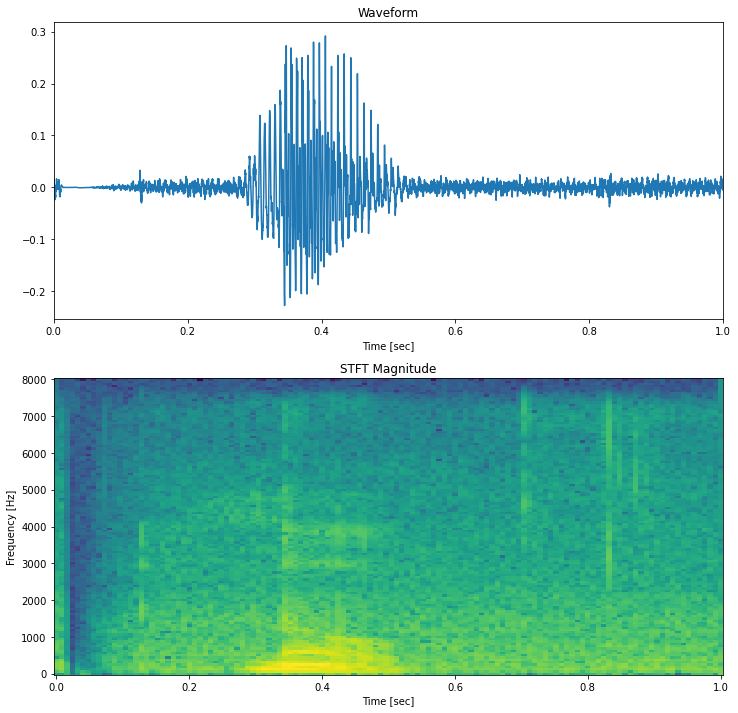

In [13]:
# len of samplerate = 1sec
target_length = samplerate
fig, axes = plt.subplots(2, figsize=(12, 12))

waveform = X_no[0][:target_length]
t = np.arange(0, waveform.shape[0]/samplerate, 1/samplerate)
axes[0].plot(t, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlabel('Time [sec]')
axes[0].set_xlim([0, target_length/samplerate]) # adjustment

f, t, log_spectrogram = get_log_spectrogram(waveform)
axes[1].pcolormesh(t, f, log_spectrogram)
axes[1].set_title('STFT Magnitude')
axes[1].set_xlabel('Time [sec]')
axes[1].set_ylabel('Frequency [Hz]')

plt.show()


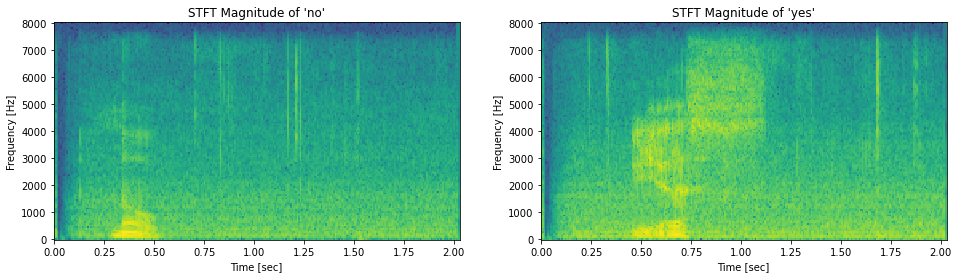

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

waveform_no = X_no[0]
f, t, log_spectrogram_no = get_log_spectrogram(waveform_no)
axes[0].pcolormesh(t, f, log_spectrogram_no)
axes[0].set_title("STFT Magnitude of 'no'")
axes[0].set_xlabel('Time [sec]')
axes[0].set_ylabel('Frequency [Hz]')

waveform_yes = X_yes[0]
f, t, log_spectrogram_yes = get_log_spectrogram(waveform_yes)
axes[1].pcolormesh(t, f, log_spectrogram_yes)
axes[1].set_title("STFT Magnitude of 'yes'")
axes[1].set_xlabel('Time [sec]')
axes[1].set_ylabel('Frequency [Hz]')

plt.show()

by librosa

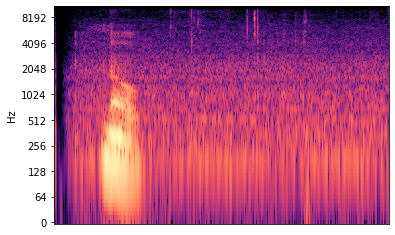

In [15]:
spec = librosa.stft(X_no[0], win_length=256)
spec_db = librosa.amplitude_to_db(np.abs(spec))
librosa.display.specshow(spec_db, y_axis="log")

### f0 score

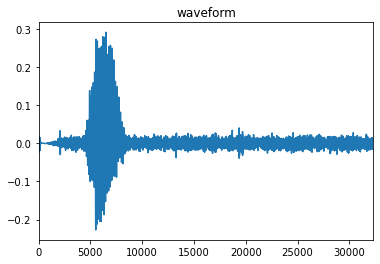

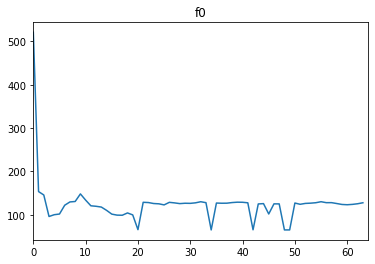

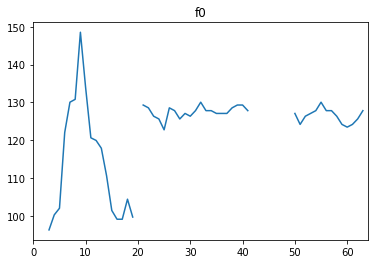

In [16]:
c2 = librosa.note_to_hz('C2')
c7 = librosa.note_to_hz('C7')

waveform = X_no[0]

plt.title("waveform")
plt.plot(waveform)
plt.xlim([0, len(waveform)]) # adjustment
plt.show()

f0 = librosa.yin(waveform, fmin=c2, fmax=c7, sr=samplerate)
plt.title("f0")
plt.plot(f0)
plt.xlim([0, len(f0)]) # adjustment
plt.show()

f0, _, _ = librosa.pyin(waveform, fmin=c2, fmax=c7, sr=samplerate)
plt.title("f0")
plt.plot(f0)
plt.xlim([0, len(f0)]) # adjustment
plt.show()

無音領域に不正値が入ってしまう

#### (補足) キレイな出力結果

In [17]:
!wget -P ./data https://tips-memo.com/wp-content/uploads/2019/12/adjust_doremi.wav

--2022-07-13 21:57:28--  https://tips-memo.com/wp-content/uploads/2019/12/adjust_doremi.wav
tips-memo.com (tips-memo.com) をDNSに問いあわせています... 183.90.237.57
tips-memo.com (tips-memo.com)|183.90.237.57|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 524346 (512K) [audio/x-wav]
`./data/adjust_doremi.wav.2' に保存中

adjust_doremi.wav.2 100%[===================>] 512.06K   701KB/s 時間 0.7s       

2022-07-13 21:57:30 (701 KB/s) - `./data/adjust_doremi.wav.2' へ保存完了 [524346/524346]



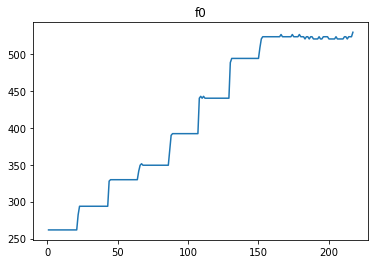

In [18]:
y, sr = librosa.load("data/adjust_doremi.wav")

f0, _, prob = librosa.pyin(y, fmin=c2, fmax=c7, sr=sr)

plt.title("f0")
plt.plot(f0)

plt.show()

### MFCC

ref. https://librosa.org/doc/main/generated/librosa.feature.mfcc.html#librosa.feature.mfcc

(20, 64)


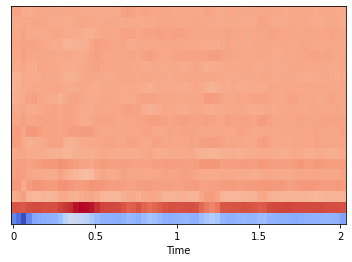

In [19]:
waveform = X_no[0]

# using S (reccomended)
S = librosa.feature.melspectrogram(y=waveform, sr=samplerate, n_mels=128,
                                   fmax=8000)
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=samplerate, x_axis='time')

### Root Mean Square

ref. https://librosa.org/doc/main/generated/librosa.feature.rms.html#librosa.feature.rms

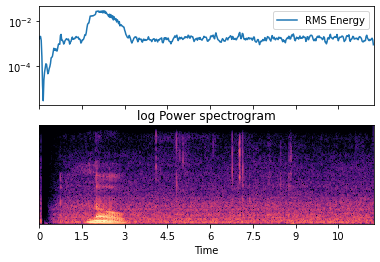

In [20]:
S = librosa.magphase(librosa.stft(X_no[0], win_length=256))[0]
rms = librosa.feature.rms(S=S)

fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                          x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

plt.show()

### Chroma Energy Normalized

ref. https://librosa.org/doc/main/generated/librosa.feature.chroma_cens.html#librosa.feature.chroma_cens

/Users/sadahiroyoshi/miniforge3/envs/torch-gpu/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=506
  return f(*args, **kwargs)


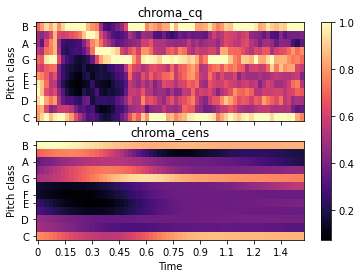

In [33]:
waveform = X_no[0]

chroma_cens = librosa.feature.chroma_cens(y=waveform, sr=samplerate)
chroma_cq = librosa.feature.chroma_cqt(y=waveform, sr=samplerate)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
img = librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].set(title='chroma_cq')
ax[0].label_outer()
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='chroma_cens')
fig.colorbar(img, ax=ax)

## 推論

In [106]:
X = []
y = []
# noを0, yesを1に
names_by_label = {
    0: "no",
    1: "yes", 
}
for no, yes in zip(X_no, X_yes):
    X.append(no)
    y.append(0)
    X.append(yes)
    y.append(1)

X = np.array(X)
y = np.array(y)

In [22]:
# fftした絶対値と位相を特徴量とする
X_fft = np.array([np.fft.fft(x) for x in X])
X_feat = [np.hstack((x.real**2+x.imag**2, np.arctan2(x.real, x.imag))) for x in X_fft]

X_feat = np.array(X_feat)

### RandomForestClassifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=seed)

scores = sklearn.model_selection.cross_val_score(clf, X_feat, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:1.000 (+/-0.000)


#### 可視化
ref. https://yolo-kiyoshi.com/2021/02/13/post-2674/

In [24]:
def proximityMatrix(model, X, normalize=True):
    """
    近接行列を算出する

    Notes:
        https://stackoverflow.com/questions/18703136/proximity-matrix-in-sklearn-ensemble-randomforestclassifier
    """

    terminals = model.apply(X)
    data_size, nTrees = terminals.shape

    proxMat = np.zeros([data_size, data_size])

    for i in range(nTrees):
        belong_node = terminals[:, i]
        proxMat += 1*np.equal.outer(belong_node, belong_node)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat

clf = sklearn.ensemble.RandomForestClassifier(random_state=seed)
clf.fit(X_feat, y)

proximity_matrix = proximityMatrix(clf, X_feat, normalize=True)
print(f'proximity_matrix.shape: {proximity_matrix.shape}')

proximity_matrix.shape: (40, 40)


In [56]:
def plot_r2dim(tsf, X, y, label_map, title):
    assert tsf.n_components == 2

    X_r2dim = tsf.fit_transform(X)

    # ラベルを追加
    tmp = np.insert(X_r2dim, X_r2dim.shape[1], y, axis=1)
    # DataFrame化
    df_for_plot = pd.DataFrame(tmp, columns=['X_1', 'X_2', 'label'])
    # ラベルを名称に変換
    df_for_plot['label'] = df_for_plot['label'].map(lambda y: label_map[int(y)])
    # 近接グラフの可視化
    sns.scatterplot(x='X_1', y='X_2', data=df_for_plot, hue='label')
    plt.title(title)
    plt.show()

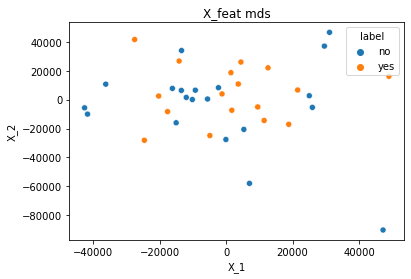

/Users/sadahiroyoshi/miniforge3/envs/torch-gpu/lib/python3.9/site-packages/sklearn/manifold/_mds.py:506: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


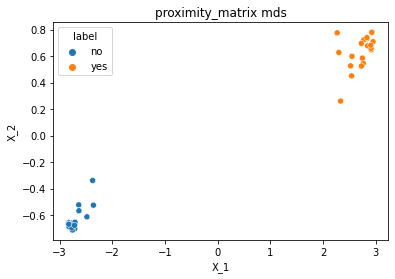

In [104]:
# 主成分抽出(mds)
mds = sklearn.manifold.MDS(n_components=2, random_state=seed)

plot_r2dim(mds, X_feat, y, names_by_label, 'X_feat mds')
plot_r2dim(mds, proximity_matrix, y, names_by_label, 'proximity_matrix mds')

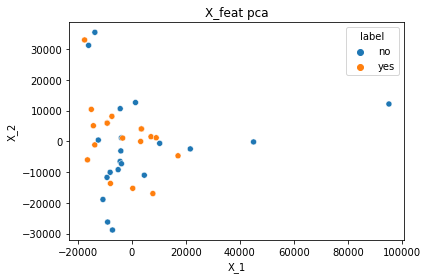

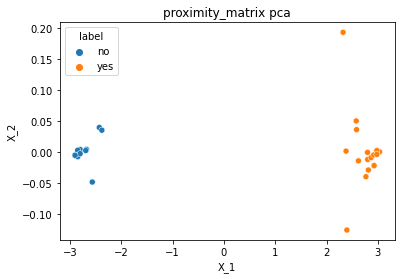

In [27]:
# 主成分抽出(PCA)
pca = sklearn.decomposition.PCA(n_components=2, random_state=seed)

plot_r2dim(pca, X_feat, y, names_by_label, 'X_feat pca')
plot_r2dim(pca, proximity_matrix, y, names_by_label, 'proximity_matrix pca')

### DecisionTreeClassifier

In [47]:
clf = sklearn.tree.DecisionTreeClassifier(random_state=seed)

scores = sklearn.model_selection.cross_val_score(clf, X_feat, y, cv=5)
print(scores)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

[0.875 0.875 1.    0.875 0.875]
score:0.900 (+/-0.100)


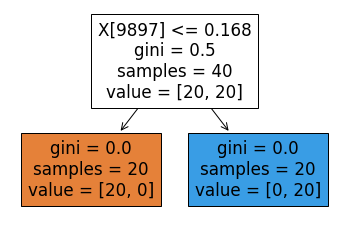

In [31]:
clf.fit(X_feat, y)

sklearn.tree.plot_tree(clf, filled=True)
plt.show()


データが簡単なので、わりと単純な決定木でも精度が出てしまう模様

### SVC

In [42]:
clf = sklearn.svm.SVC(random_state=seed)

scores = sklearn.model_selection.cross_val_score(clf, X_feat, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:0.625 (+/-0.158)


#### 別の特徴量を利用して予測

In [191]:
# mfcc

X_mfcc = []
for x in X:
    S = librosa.feature.melspectrogram(y=x, sr=samplerate, n_mels=128,
                                   fmax=8000)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
    X_mfcc.append(np.array(mfcc).flatten())

X_mfcc = np.array(X_mfcc)
X_mfcc.shape

/Users/sadahiroyoshi/miniforge3/envs/torch-gpu/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2
  return f(*args, **kwargs)


(40, 20)

In [44]:
scores = sklearn.model_selection.cross_val_score(clf, X_mfcc, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:0.950 (+/-0.122)


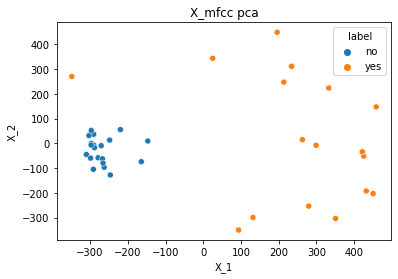

In [49]:
# 主成分抽出(PCA)
pca = sklearn.decomposition.PCA(n_components=2, random_state=seed)

plot_r2dim(pca, X_mfcc, y, names_by_label, 'X_mfcc pca')

In [51]:
X_mfcc_pca = pca.fit_transform(X_mfcc)

scores = sklearn.model_selection.cross_val_score(clf, X_mfcc_pca, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:0.975 (+/-0.100)


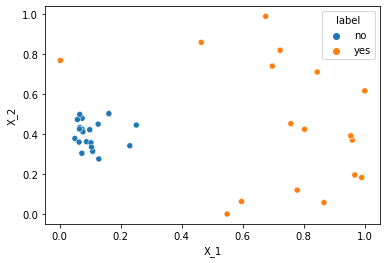

In [95]:
# min-max normalization
X_mfcc_pca_minmax = (X_mfcc_pca - X_mfcc_pca.min())/(X_mfcc_pca.max() - X_mfcc_pca.min())

# ラベルを追加
tmp = np.insert(X_mfcc_pca_minmax, X_mfcc_pca_minmax.shape[1], y, axis=1)
# DataFrame化
df_for_plot = pd.DataFrame(tmp, columns=['X_1', 'X_2', 'label'])
# ラベルを名称に変換
df_for_plot['label'] = df_for_plot['label'].map(lambda y: names_by_label[int(y)])
# 近接グラフの可視化
sns.scatterplot(x='X_1', y='X_2', data=df_for_plot, hue='label')
plt.show()


In [126]:
# gammmaが大きいほど境界が複雑になり、Cが小さいほど誤分類を許容します。
# ref. https://algorithm.joho.info/programming/python/scikit-learn-svm-plot/
def plot_svm_border(
    ax,
    X,
    min,
    max,
    gamma,
    C,
    kernel="rbf",
):
    clf = sklearn.svm.SVC(gamma=gamma, C=C, kernel=kernel, random_state=seed)
    clf.fit(X, y)

    # 境界線プロット用の格子状データを生成
    x1 = np.linspace(min, max, 100)
    x2 = np.linspace(min, max, 100)
    X1, X2 = np.meshgrid(x1, x2)    
    plot_X = np.c_[X1.ravel(), X2.ravel()]

    plot_y = clf.predict(plot_X)

    # 格子データで散布図をプロットし、決定境界を描画（y=0:blue, y=1:red）
    ax.scatter(plot_X.T[0][plot_y <= 0], plot_X.T[1][plot_y <= 0], marker='o', color="blue", alpha=0.1)
    ax.scatter(plot_X.T[0][plot_y > 0], plot_X.T[1][plot_y > 0], marker='o', color="red", alpha=0.1)

    # 学習用データを散布図にプロット（y=0:blue, y=1:red）
    ax.scatter(X.T[0][y <= 0], X.T[1][y <= 0], marker='o', color="blue", alpha=1.0)
    ax.scatter(X.T[0][y > 0], X.T[1][y > 0], marker='o', color="red", alpha=1.0)

    ax.set_xlabel('x1')            # x軸ラベル
    ax.set_ylabel('x2')            # y軸ラベル
    ax.set_xlim([min, max])
    ax.set_ylim([min, max])

    scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=5)
    score = scores.mean()
    ax.set_title(f"gamma={gamma} C={C} kernel={kernel} score={score}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


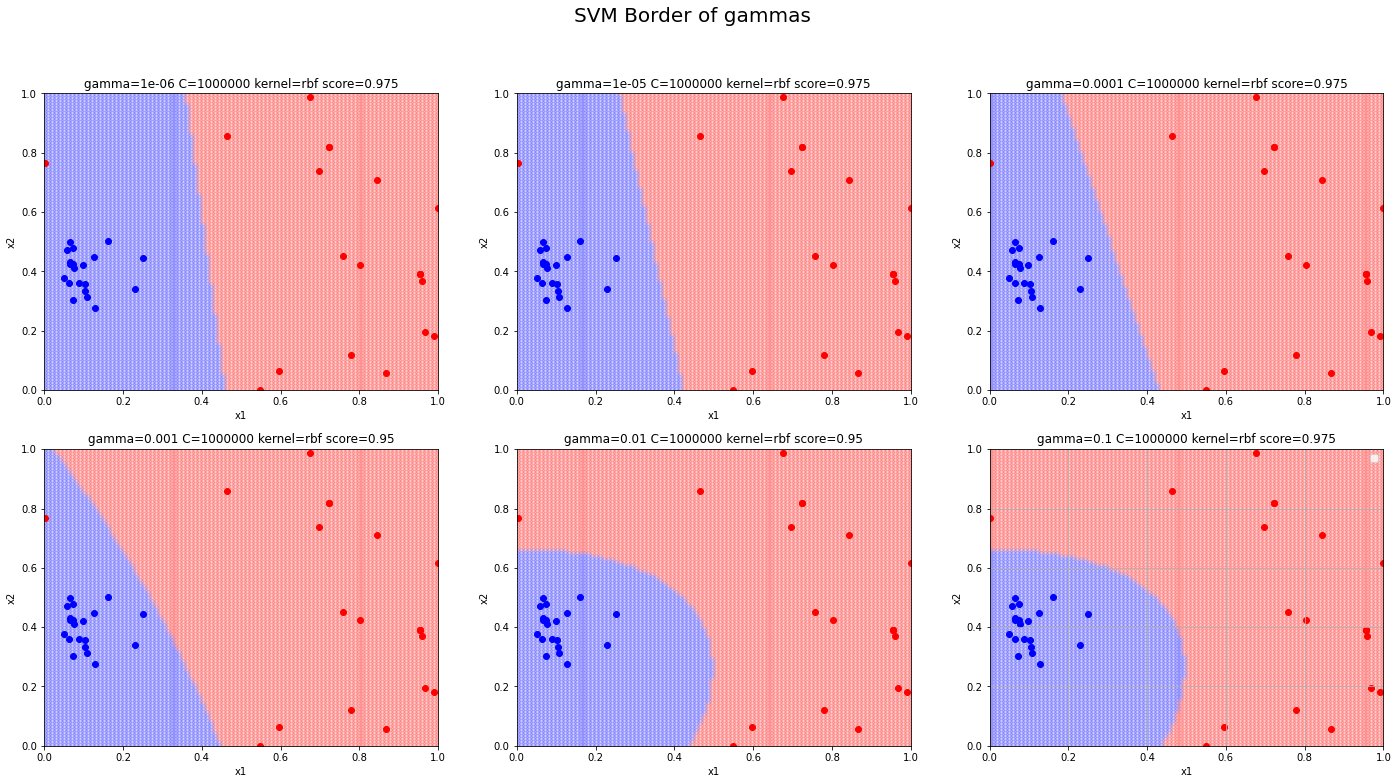

In [157]:
# C固定
C = 1000000
gammas = [
    0.000001,
    0.00001,
    0.0001,
    0.001,
    0.01,
    0.1,
]

n = len(gammas)
cols = 3
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
fig.suptitle("SVM Border of gammas", fontsize=20)

for i, gamma in enumerate(gammas):
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    plot_svm_border(
        ax=ax,
        X=X_mfcc_pca_minmax,
        min=0,
        max=1,
        gamma=gamma,
        C=C,
    )

    if i+1 >= n:
        break

plt.grid()
plt.legend(loc=1)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


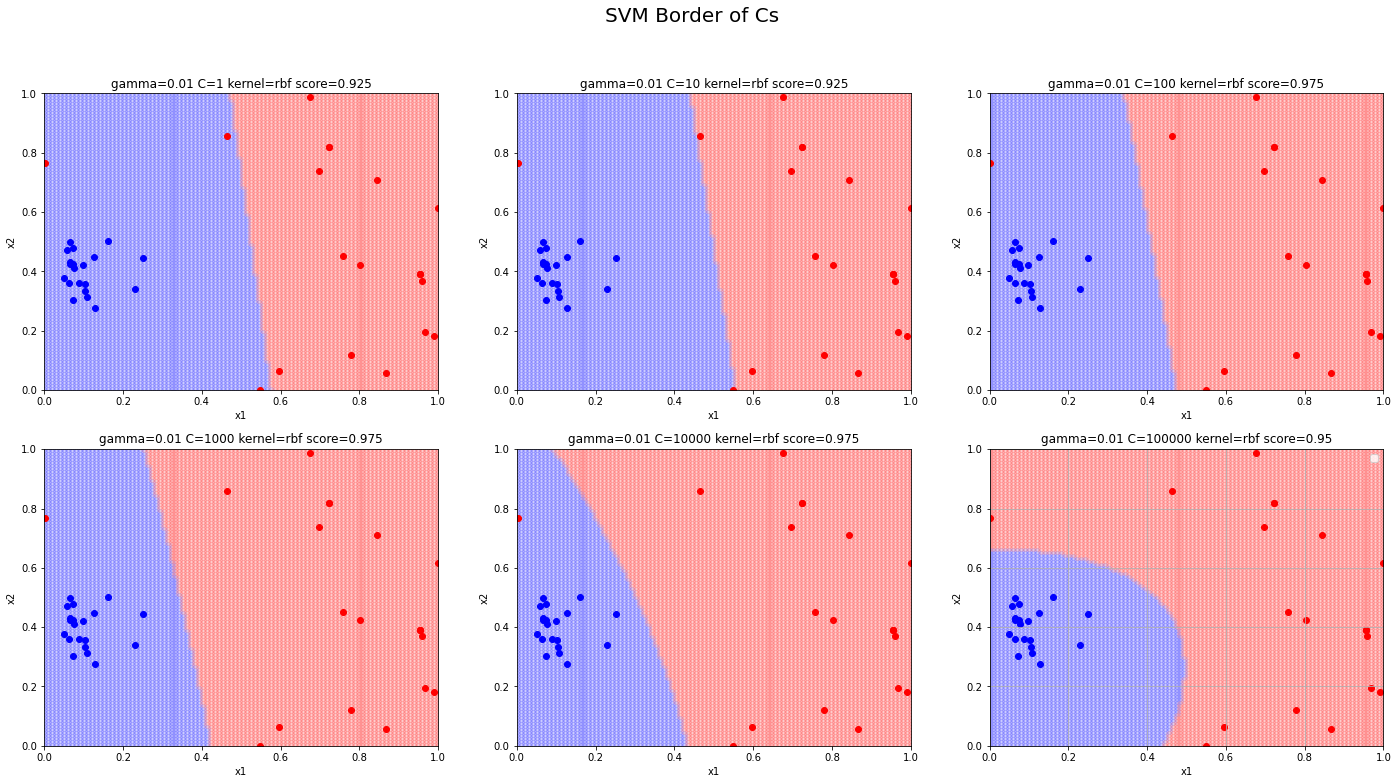

In [158]:
# gamma固定
gamma = 0.01
Cs = [
    1,
    10,
    100,
    1000,
    10000,
    100000,
]

n = len(Cs)
cols = 3
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
fig.suptitle("SVM Border of Cs", fontsize=20)

for i, C in enumerate(Cs):
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    plot_svm_border(
        ax=ax,
        X=X_mfcc_pca_minmax,
        min=0,
        max=1,
        gamma=gamma,
        C=C,
    )

    if i+1 >= n:
        break

plt.grid()
plt.legend(loc=1)
plt.show()


### KNeighborsClassifier

In [61]:
clf = sklearn.neighbors.KNeighborsClassifier()

scores = sklearn.model_selection.cross_val_score(clf, X_feat, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

scores = sklearn.model_selection.cross_val_score(clf, X_mfcc, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

scores = sklearn.model_selection.cross_val_score(clf, X_mfcc_pca, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:0.550 (+/-0.255)
score:0.975 (+/-0.100)
score:0.975 (+/-0.100)


### GradientBoostingClassifier

In [62]:
clf = sklearn.ensemble.GradientBoostingClassifier(random_state=seed)

scores = sklearn.model_selection.cross_val_score(clf, X_feat, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

scores = sklearn.model_selection.cross_val_score(clf, X_mfcc, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

scores = sklearn.model_selection.cross_val_score(clf, X_mfcc_pca, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:0.975 (+/-0.100)
score:0.900 (+/-0.292)
score:0.975 (+/-0.100)


[参考記事](https://aidemy.net/magazine/661/)とは異なり、RamdomForestが100%正解を出したため  
GradientBoostingClassifierよりも精度がいいという結果に  

## ノイズ付与

In [189]:
def add_noise(X):
    random_noise = np.random.randn(len(X), len(X[0]))
    # min-max
    random_noise = (random_noise - random_noise.min())/(random_noise.max() - random_noise.min())
    # -0.75~0.75
    random_noise = random_noise * 1.5 - 1

    result = X + random_noise
    result = np.clip(result, -1, 1)
    return result

max: 0.497344970703125
min: -1.0


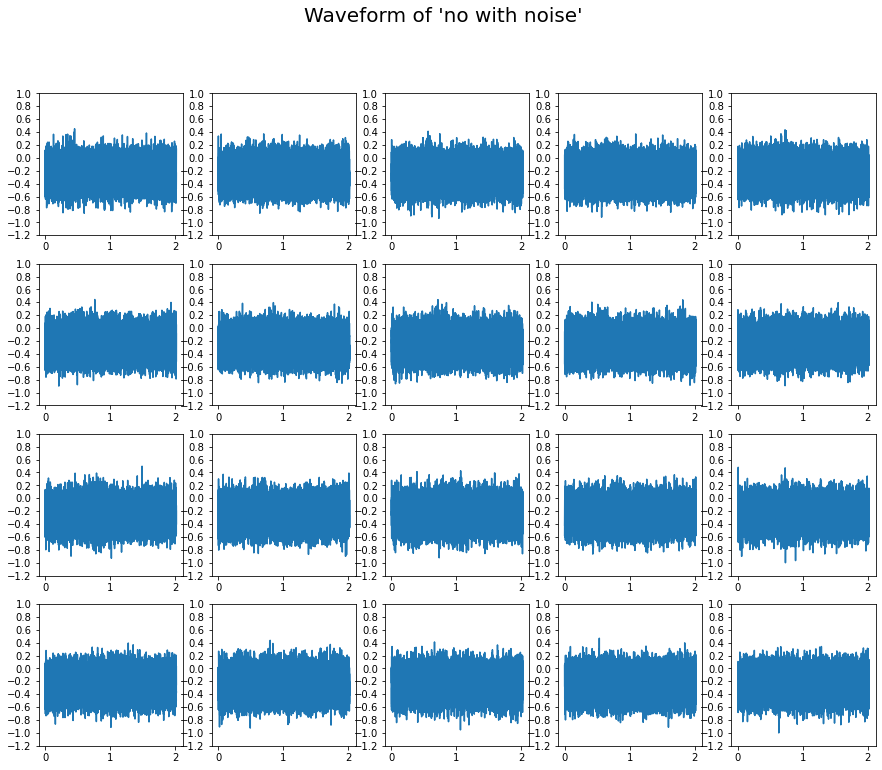

In [190]:
X_no_noise = add_noise(X_no)

print(f"max: {X_no_noise.max()}")
print(f"min: {X_no_noise.min()}")

plot_samples(X_no_noise, "no with noise")

In [186]:
print('Audio playback')
display.display(display.Audio(X_no_noise[0], rate=samplerate))

Audio playback


ひとの耳でギリギリ認識できるレベル

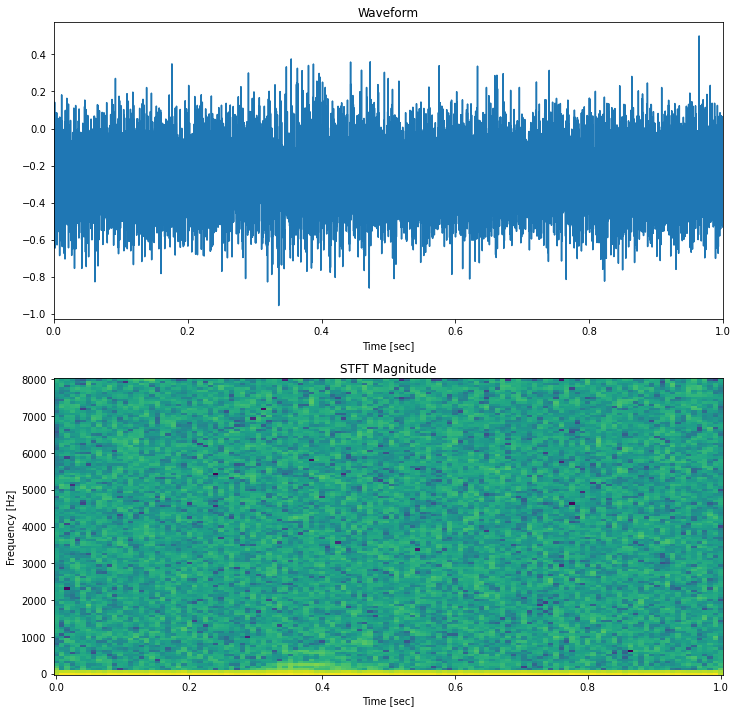

In [187]:
# len of samplerate = 1sec
target_length = samplerate
fig, axes = plt.subplots(2, figsize=(12, 12))

waveform = X_no_noise[0][:target_length]
t = np.arange(0, waveform.shape[0]/samplerate, 1/samplerate)
axes[0].plot(t, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlabel('Time [sec]')
axes[0].set_xlim([0, target_length/samplerate]) # adjustment

f, t, log_spectrogram = get_log_spectrogram(waveform)
axes[1].pcolormesh(t, f, log_spectrogram)
axes[1].set_title('STFT Magnitude')
axes[1].set_xlabel('Time [sec]')
axes[1].set_ylabel('Frequency [Hz]')

plt.show()

In [224]:
X_noise =add_noise(X)

# fft
X_noise_fft = np.array([np.fft.fft(x) for x in X_noise])
X_noise_feat = [np.hstack((x.real**2+x.imag**2, np.arctan2(x.real, x.imag))) for x in X_noise_fft]

X_noise_feat = np.array(X_noise_feat)

# mfcc
X_noise_mfcc = []
for x in X_noise:
    S = librosa.feature.melspectrogram(y=x, sr=samplerate)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
    X_noise_mfcc.append(np.array(mfcc).flatten())

X_noise_mfcc = np.array(X_noise_mfcc)

/Users/sadahiroyoshi/miniforge3/envs/torch-gpu/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2
  return f(*args, **kwargs)


### RandomForestClassifier

In [225]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=seed)

scores = sklearn.model_selection.cross_val_score(clf, X_noise_feat, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:0.725 (+/-0.292)


### GradientBoostingClassifier

In [226]:
clf = sklearn.ensemble.GradientBoostingClassifier(random_state=seed)

scores = sklearn.model_selection.cross_val_score(clf, X_noise_feat, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

scores = sklearn.model_selection.cross_val_score(clf, X_noise_mfcc, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:0.775 (+/-0.292)
score:0.750 (+/-0.158)


ノイズの内容によって07~0.8あたりの精度になる  

RandomForestClassifier, GradientBoostingClassifier のどちらがいいとは言い切れないが、  
fft特徴量のほうがmfccより精度が高いことが多い